In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3, SO3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from spatialmath.base import trotx, troty, trotz
import roboticstoolbox as rtb
# Fix for notebooks: add the parent directory to sys.path
notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent.parent))

# Now import your custom robot class
from classrobot.UR5e_DH import UR5eDH
import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH, PrismaticDH
from classrobot.robot_movement import RobotControl

import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # สำหรับการ plot 3D
import rtde_receive


TCP Position in World Frame:
   0.009948  0.02428   0.9997    0.6981    
   0.6959   -0.7181    0.01051   0.283     
   0.7181    0.6956   -0.02404   0.2206    
   0         0         0         1         

Goal Position in World Frame:
  -0.1235   -0.05854   0.9906    0.7012    
  -0.7634    0.6434   -0.05717   0.08427   
  -0.634    -0.7633   -0.1242   -0.4371    
   0         0         0         1         



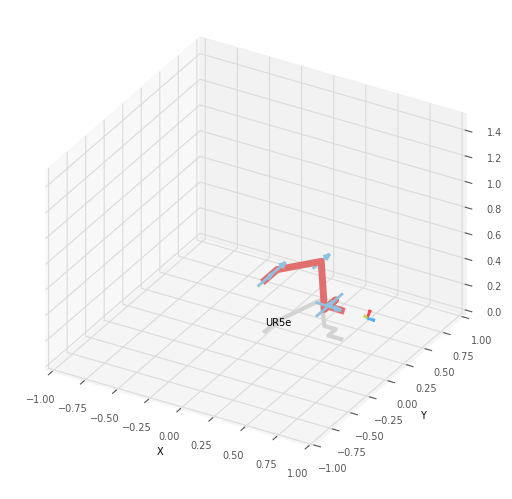

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.11499999999999998, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [115]:

# Robot DH parameters
# ================= UR5e Forward Kinematics =================
L1 = rtb.RevoluteDH(d=0.1625, a=0, alpha=np.pi/2, m=3.761, r=[0, -0.02561, 0.00193], I=np.zeros((3, 3)))
L2 = rtb.RevoluteDH(d=0, a=-0.425, alpha=0, m=8.058, r=[0.2125, 0, 0.11336], I=np.zeros((3, 3)))
L3 = rtb.RevoluteDH(d=0, a=-0.3922, alpha=0, m=2.846, r=[0.15, 0, 0.0265], I=np.zeros((3, 3)))
L4 = rtb.RevoluteDH(d=0.1333, a=0, alpha=np.pi/2, m=1.37, r=[0, -0.0018, 0.01634], I=np.zeros((3, 3)))
L5 = rtb.RevoluteDH(d=0.0997, a=0, alpha=-np.pi/2, m=1.3, r=[0, 0.0018, 0.01634], I=np.zeros((3, 3)))
I6 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0.0002]])
L6 = rtb.RevoluteDH(d=0.0996, a=0, alpha=0, m=0.365, r=[0, 0, -0.001159], I=I6)

robotDH = rtb.DHRobot([L1, L2, L3, L4, L5, L6], name='UR5e')
T_tool = SE3(0, 0, 0.200)  # 0.200 m = 200 mm
robotDH.tool = T_tool


# Define the world (table) transformation:
T_table = SE3(0, 0.4, -0.115) * SE3.Rx(np.deg2rad(90)) * SE3.Ry(0) * SE3.Rz(0)
T_table_inv = T_table.inv()
# Set the robot's base transformation:
robotDH.base = T_table_inv
q =  [0.7197909355163574, -1.9388791523375453, -2.0522477626800537, 
      -2.2783595524229945, -0.8750937620746058, 2.3630921840667725]
T_fk = robotDH.fkine(q)
T_TCP = T_fk 
T_TCP_world =  T_TCP
print("TCP Position in World Frame:")
print(T_TCP_world)
pos_goal = [0.7011797304915488, 0.18427154391614353-0.1, -0.43708867396716417,
            -1.7320526609998639, 0.6867495616307455, -1.7312152841633146]
T_end   = SE3(pos_goal[0], pos_goal[1], pos_goal[2]) @ SE3.RPY(pos_goal[3], pos_goal[4], pos_goal[5], unit='rad')
print("Goal Position in World Frame:")
print(T_end)
robotDH.plot(q, block=False, limits=[-1, 1, -1, 1, 0, 1.5])

In [86]:
def cubic_trajectory_planning(p0, p1, v0, v1, T, dt):
    """
    Compute a cubic polynomial trajectory for a single coordinate.
    
    The polynomial is:
        p(t) = a*t^3 + b*t^2 + v0*t + p0
    with coefficients:
        a = [2*(p0 - p1) + (v0 + v1)*T] / T^3
        b = [3*(p1 - p0) - (2*v0 + v1)*T] / T^2

    Args:
        p0, p1: Initial and final positions.
        v0, v1: Initial and final velocities.
        T: Total trajectory duration.
        dt: Time step.

    Returns:
        t   : Time vector.
        pos : Position along the trajectory.
        vel : Velocity along the trajectory.
        acc : Acceleration along the trajectory.
    """
    if T <= 0:
        raise ValueError("Total time T must be positive.")
    
    t = np.linspace(0, T, int(T / dt) + 1)
    a = (2 * (p0 - p1) + (v0 + v1) * T) / (T ** 3)
    b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T ** 2)
    
    pos = a * t**3 + b * t**2 + v0 * t + p0
    vel = 3 * a * t**2 + 2 * b * t + v0
    acc = 6 * a * t + 2 * b
    
    return t, pos, vel, acc


def compute_trajectory_time(d, v_tool, a_max):
    """
    Compute the total trajectory time based on the distance d, the desired tool speed v_tool, 
    and the maximum acceleration a_max. It chooses between a triangular or trapezoidal velocity profile.

    Parameters:
        d      : Distance between start and goal [m]
        v_tool : Desired tool speed [m/s]
        a_max  : Maximum allowable acceleration [m/s^2]

    Returns:
        T_total : Total trajectory time [s]
        profile : String indicating which profile is used ('Triangular' or 'Trapezoidal')
    """
    if d <= 0 or v_tool <= 0 or a_max <= 0:
        raise ValueError("Distance, tool speed, and acceleration must be positive.")
    
    # Check if the move is too short to reach the desired speed
    if d < (v_tool ** 2) / a_max:
        # Triangular profile
        T_total = 2 * np.sqrt(d / a_max)
        profile = 'Triangular'
    else:
        # Trapezoidal profile
        T_accel = v_tool / a_max
        d_accel = 0.5 * a_max * T_accel ** 2
        d_ramps = 2 * d_accel
        T_total = 2 * T_accel + (d - d_ramps) / v_tool
        profile = 'Trapezoidal'
    
    return T_total, profile

def plot_velocity_profile(T_total, profile, v_tool, a_max):
    if profile == 'Triangular':
        t_peak = T_total / 2
        t = np.linspace(0, T_total, 100)
        v = np.where(t < t_peak, a_max * t, a_max * (T_total - t))
    else:
        T_accel = v_tool / a_max
        t_cruise = T_total - 2 * T_accel
        t = np.linspace(0, T_total, 100)
        v = np.piecewise(t,
                         [t < T_accel, (t >= T_accel) & (t < T_accel + t_cruise), t >= T_accel + t_cruise],
                         [lambda t: a_max * t, v_tool, lambda t: v_tool - a_max * (t - (T_accel + t_cruise))])
    plt.plot(t, v)
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title(f'{profile} Velocity Profile')
    plt.show()

def pose_to_fk_matrix(pose):
    """
    Convert a 6-element pose into a 4x4 homogeneous transformation matrix.
    
    Parameters:
        pose: A list or array with 6 elements [x, y, z, roll, pitch, yaw].
              - [x, y, z]  : Translation components.
              - [roll, pitch, yaw] : Rotations in radians (assumed ZYX order).
    
    Returns:
        T: 4x4 numpy array representing the transformation matrix.
    """
    tx, ty, tz, roll, pitch, yaw = pose

    # Rotation about Z-axis (yaw)
    Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                   [np.sin(yaw),  np.cos(yaw), 0],
                   [0,            0,           1]])
    
    # Rotation about Y-axis (pitch)
    Ry = np.array([[np.cos(pitch),  0, np.sin(pitch)],
                   [0,              1, 0],
                   [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Rotation about X-axis (roll)
    Rx = np.array([[1, 0,           0],
                   [0, np.cos(roll), -np.sin(roll)],
                   [0, np.sin(roll),  np.cos(roll)]])
    
    # Compose rotations in ZYX order: first yaw, then pitch, then roll.
    R = Rz @ Ry @ Rx  # using the @ operator for matrix multiplication
    
    # Build the homogeneous transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = [tx, ty, tz]
    
    return T

In [90]:
# --- 4. Generate a Cartesian trajectory between the two TCP poses ---

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_TCP_world.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.1     # Desired tool speed in m/s
a_max = 1.2     # Maximum acceleration in m/s^2
T_total, profile = compute_trajectory_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))
dt = 1/100      # Control loop time step
# Time vector for the trajectory
t_vec = np.linspace(0, T_total, int(T_total / dt) + 1)

# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array
acc_tracj = np.zeros((len(t_vec), 3))  # Initialize acceleration trajectory array

for i in range(3):
    time, pos_i, speed_i, acc_i = cubic_trajectory_planning(pos_start[i], pos_end[i],
                                                            v0_cart, v1_cart,
                                                            T_total, dt)
    pos_traj[:, i] = pos_i[:len(t_vec)]  # Ensure the lengths match
    speed_traj[:, i] = speed_i[:len(t_vec)]
    acc_tracj[:, i] = acc_i[:len(t_vec)]
    # print(f"pos_traj[:, {i}]: {pos_traj[:, i]}")
    # print(f"speed[:, {i}]: {speed}")
    # print(f"acc[:, {i}]: {acc}")

# Check the endpoints for speed (should be 0)
print("Speed at start (x-axis):", speed_traj[0, 0])
print("Speed at end (x-axis):", speed_traj[-1, 0])
print("Number of trajectory points:", len(pos_traj))


# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))

# For the orientation, interpolate using the SE3.interp method.
traj_T = []
for j, t in enumerate(t_vec):
    s = t / T_total  # normalized time [0, 1]
    # Interpolate the full SE3 pose
    T_interp = T_TCP_world.interp(T_end, s)
    # Replace the translation with the cubic trajectory value for consistency
    T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])  # Ensure R is a 3x3 rotation matrix
    traj_T.append(T_interp)

print("Interpolated TCP poses:")
# for T in traj_T:
#     print(T)
waypoints = []
for T in traj_T:
    # เก็บ SE3 pose ตรง ๆ เข้า waypoints
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print("Waypoints final pose:")
print(waypoints[-1])
print("Waypoints start pose:")
print(waypoints[0])


Start position: [0.69813131 0.28296108 0.22058993]
End position: [ 0.70117973  0.08427154 -0.43708867]
Distance between start and end position: 0.6870429139474921
Selected Profile: Trapezoidal
Total Trajectory Time: 6.954 seconds
Speed at start (x-axis): 0.0
Speed at end (x-axis): -4.336808689942018e-19
Number of trajectory points: 696
Number of points in the trajectory: 696
Interpolated TCP poses:
Total Waypoint: 696
Waypoints final pose:
  -0.1235   -0.05854   0.9906    0.7012    
  -0.7634    0.6434   -0.05717   0.08427   
  -0.634    -0.7633   -0.1242   -0.4371    
   0         0         0         1         

Waypoints start pose:
   0.009948  0.02428   0.9997    0.6981    
   0.6959   -0.7181    0.01051   0.283     
   0.7181    0.6956   -0.02404   0.2206    
   0         0         0         1         



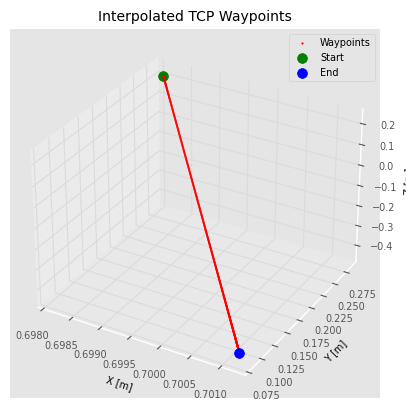

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create an array of translations from the waypoints:
positions = np.array([T.t for T in waypoints])  # Shape: (n_points, 3)

# Now let's plot them:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory line connecting the waypoints
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='red', label="Waypoints", s=1)

# Optionally, add markers for the start and end positions
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Interpolated TCP Waypoints')
ax.legend()
plt.show()


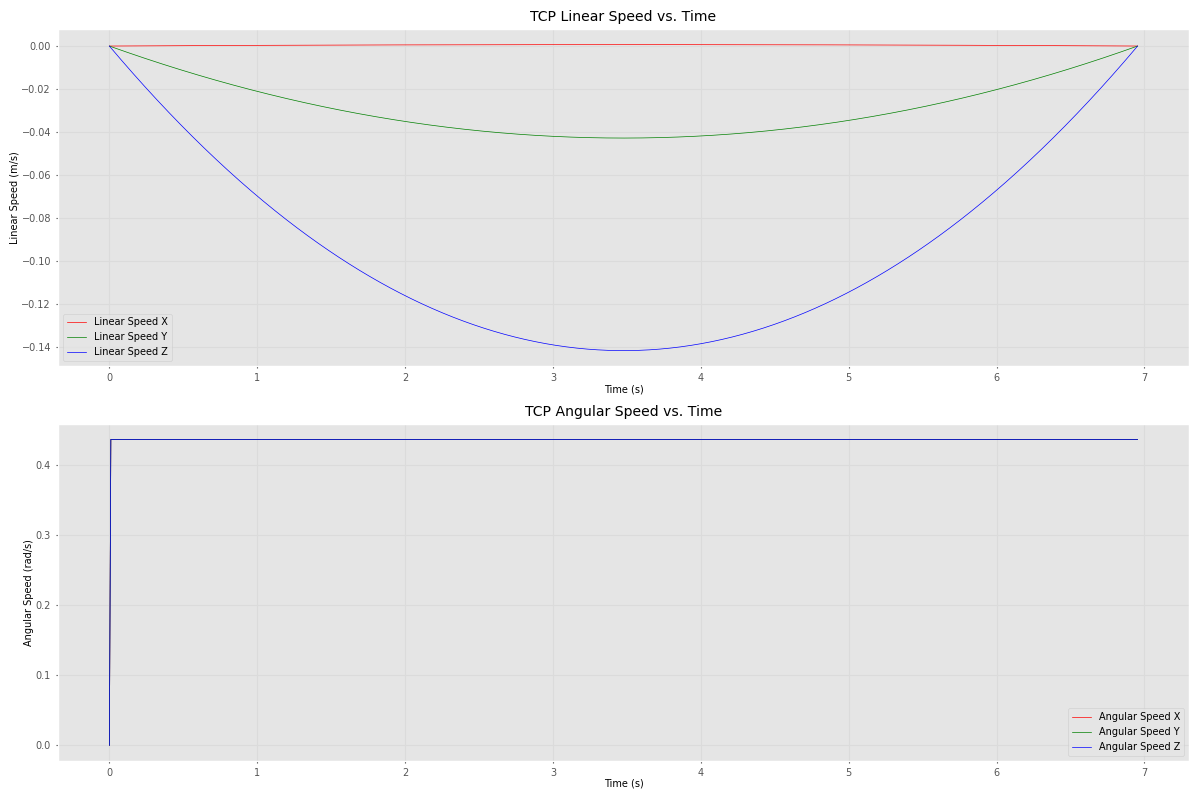

In [92]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate angular speeds from SE3 poses
angular_speeds = np.zeros((len(traj_T), 3))  # Initialize array for angular speeds
for i in range(1, len(traj_T)):
    # Compute the relative transformation between consecutive poses
    delta_T = traj_T[i - 1].inv() * traj_T[i]
    # Extract the angular velocity (rotation vector) from the relative transformation
    angular_speeds[i, :] = delta_T.angvec()[0] / dt  # Divide by dt to get angular speed

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot linear speeds
plt.subplot(2, 1, 1)
plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear Speed X')  # Red line for X axis speed
plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Speed Y')  # Green line for Y axis speed
plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Speed Z')  # Blue line for Z axis speed
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot angular speeds
plt.subplot(2, 1, 2)
plt.plot(t_vec, angular_speeds[:, 0], 'r-', label='Angular Speed X')  # Red line for X axis angular speed
plt.plot(t_vec, angular_speeds[:, 1], 'g-', label='Angular Speed Y')  # Green line for Y axis angular speed
plt.plot(t_vec, angular_speeds[:, 2], 'b-', label='Angular Speed Z')  # Blue line for Z axis angular speed
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [107]:
# ========== 1. Solve Inverse Kinematics ==========
q_trajectory = []
q_prev = q.copy()  # Start from current joints (ensure copy to avoid modification)

for pose in waypoints:
    # First attempt with previous solution as seed
    ik_result = robotDH.ikine_LM(pose, q0=q_prev)
    
    # Fallback: Random restart if first attempt fails
    if not ik_result.success:
        ik_result = robotDH.ikine_LM(pose, q0=np.random.uniform(-np.pi, np.pi, 6))
        if not ik_result.success:
            print(f"IK failed for pose: {pose}")
            continue
    
    q_trajectory.append(ik_result.q)
    q_prev = ik_result.q.copy()  # Update seed

# Convert to numpy array with proper shape (N,6)
q_traj_array = np.vstack(q_trajectory) if q_trajectory else np.empty((0,6))

IK failed for pose:   -0.07581  -0.0906    0.993     0.7007    
  -0.9956   -0.04849  -0.08043   0.1144    
   0.05544  -0.9947   -0.08652  -0.3372    
   0         0         0         1         

IK failed for pose:   -0.07615  -0.09052   0.993     0.7007    
  -0.9958   -0.04412  -0.08038   0.1141    
   0.05109  -0.9949   -0.08678  -0.3383    
   0         0         0         1         

IK failed for pose:   -0.07648  -0.09044   0.993     0.7007    
  -0.996    -0.03976  -0.08034   0.1138    
   0.04674  -0.9951   -0.08704  -0.3393    
   0         0         0         1         

IK failed for pose:   -0.07682  -0.09037   0.9929    0.7007    
  -0.9961   -0.03539  -0.08029   0.1135    
   0.0424   -0.9953   -0.0873   -0.3404    
   0         0         0         1         

IK failed for pose:   -0.07715  -0.09029   0.9929    0.7007    
  -0.9963   -0.03102  -0.08023   0.1132    
   0.03805  -0.9954   -0.08756  -0.3414    
   0         0         0         1         

IK failed for p

Max velocity: 313.74 rad/s


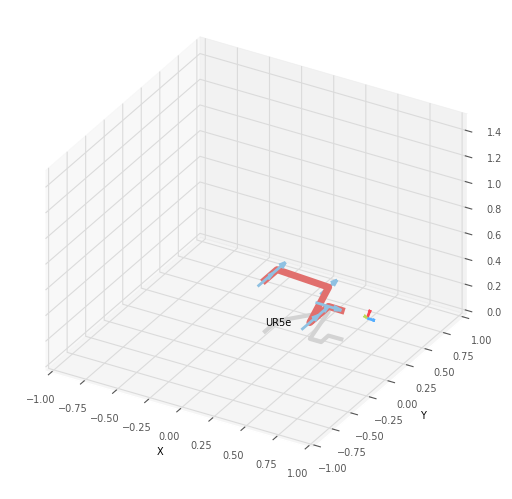

<Figure size 640x480 with 0 Axes>

In [110]:
# ========== 2. Validate Joint Trajectory ==========
if len(q_traj_array) > 1:
    dt = 1/100  # Time step
    qdot = np.gradient(q_traj_array, axis=0) / dt
    
    # Check velocity limits (UR5e max ~ π rad/s)
    if np.any(np.abs(qdot) > np.pi):
        print("Warning: Joint velocity limits exceeded!")
        print(f"Max velocity: {np.max(np.abs(qdot)):.2f} rad/s")
else:
    print("Not enough points for velocity calculation")

# ========== 3. Plot/Animate ==========
if len(q_traj_array) > 0:
    robotDH.plot(
        q_traj_array,  # Downsample every 5 points
        backend='pyplot',
        movie='ur5e_move.gif',
        limits=[-1, 1, -1, 1, 0, 1.5],
        vellipse=False
    )
    plt.show()
else:
    print("No valid trajectory to plot")